In [31]:
import numpy as n
import napari
import os
import tifffile
import skimage

In [32]:
from matplotlib import pyplot as plt

In [3]:
data_dir = r'X:\LBM-calibration\2023-12-29'

In [4]:
files = ['spheres_10xslide_2xzoom_4umstep_50frame_00001.tif']

In [182]:
zstep_um = 4
smart_peaks = True
manual_selection_fuzz_pix = 10
n_filter_in_z = 0.5


In [153]:
data = []
for file in files:
    tif_path = os.path.join(data_dir, file)
    file_data = tifffile.imread(tif_path)
    data.append(file_data)

<tifffile.TiffFile 'spheres_10xslid…0frame_00001.tif'> asarray failed to reshape (1890, 144, 144) to (2, 50, 15, 144, 144)


In [154]:
data = n.concatenate(data,axis=0)

In [155]:
tif = tifffile.TiffFile(tif_path)
n_channels = len(tif.scanimage_metadata['FrameData']['SI.hChannels.channelSave'])
scanimage_fov_um = n.array(tif.scanimage_metadata['FrameData']['SI.hRoiManager.imagingFovUm'])
n_y_um = scanimage_fov_um[:,0].max() - scanimage_fov_um[:,0].min()
n_x_um = scanimage_fov_um[:,1].max() - scanimage_fov_um[:,1].min()
ny, nx = data.shape[1:]

In [213]:
psize_x = n_x_um / nx
psize_y = n_y_um / ny

In [157]:
data = data.reshape(-1, n_channels,ny,nx)

In [158]:
nstep, nz = data.shape[:2]

In [159]:
channels = n.arange(nz)
norms = n.linalg.norm(data,axis=(2,3))
zpos_max_signal = norms.argmax(axis=0)
zpos_max_signal_um = zpos_max_signal * zstep_um
best_img_per_plane = n.zeros((nz, ny, nx))
for i in range(n_channels):
    best_img_per_plane[i] = data[zpos_max_signal[i], i]

In [160]:
viewer = napari.view_image(best_img_per_plane, name='sample')
viewer.add_points(ndim = 3, symbol='x', size=1, face_color='red', name='annotation')
viewer.layers['sample']._keep_auto_contrast = True

In [ ]:
selected_points = viewer.layers['annotation'].data
viewer.close()

In [ ]:
locs = selected_points[n.argsort(selected_points[:,0])]

spheres = [locs]

n_spheres = 1

spheres_locs = n.zeros((n_spheres, nstep, nz, 2)) * n.nan
spheres_vals = n.zeros((n_spheres, nstep, nz)) * n.nan
for zidx in range(nz):
    thresh = best_img_per_plane[zidx].max() * 0.05
    for step_idx in range(nstep):
        if smart_peaks: peaks = skimage.feature.peak_local_max(data[step_idx, zidx], threshold_abs = thresh)
        if len(peaks) == 0: continue
        for sidx, sphere in enumerate(spheres):
            idx = n.where(sphere[:,0] == zidx)[0]
            if len(idx) < 1: 
                continue
            else: idx = idx[0]
            if smart_peaks: 
                argmin = n.argmin(n.linalg.norm(peaks - sphere[idx][1:],axis=1))
                closest_peak = peaks[argmin]
            else: closest_peak = sphere[idx][1:].astype(int)
            if n.linalg.norm(closest_peak - sphere[idx][1:]) < manual_selection_fuzz_pix:
                spheres_locs[sidx, step_idx, zidx] = closest_peak
                spheres_vals[sidx, step_idx, zidx] = data[step_idx,zidx, closest_peak[0], closest_peak[1]]
sphere_locs = spheres_locs[0]
sphere_vals = spheres_vals[0]

In [163]:
from scipy.ndimage import gaussian_filter1d

In [228]:
if n_filter_in_z is not None and n_filter_in_z > 0:
    sphere_vals_use = gaussian_filter1d(sphere_vals, n_filter_in_z, axis=0)    
else:
    sphere_vals_use = sphere_vals

In [229]:
max_steps = n.nanargmax(sphere_vals_use, axis=0)
max_vals = n.nanmax(sphere_vals_use, axis=0)
max_locs = n.array([sphere_locs[max_steps[i],i] for i in range(n_channels)])

In [468]:
plot_cube_um_syx = (50, 50, 50)
plot_cube_halfpix_syx = n.ceil((n.array(plot_cube_um_syx) /2) / n.array((zstep_um, psize_y, psize_x))).astype(int)
ds, dy, dx = plot_cube_halfpix_syx

In [469]:
sphere_coords = n.concatenate([max_steps[:,n.newaxis], max_locs],axis=1).astype(int)

In [302]:
planes = n.arange(n_channels)
inter_planes = planes[1:] - 0.5
steps_um = n.arange(nstep) * zstep_um

In [319]:
best_zpos_um = max_steps * zstep_um
inter_plane_um = n.diff(best_zpos_um)
xy_pos_um = (max_locs - max_locs[0]) * n.array([psize_y, psize_x])
best_powers = max_vals
power_ratios = best_powers[1:] / best_powers[:-1]

In [289]:
best_zpos_um_polyfit = n.polyfit(planes, best_zpos_um, 2)
best_zpos_um_poly = best_zpos_um_polyfit[0] * planes**2 +best_zpos_um_polyfit[1] * planes + best_zpos_um_polyfit[2]
inter_plane_um_polyfit = n.polyfit(inter_planes, inter_plane_um, 2)
inter_plane_um_poly = inter_plane_um_polyfit[0] * inter_planes**2 + inter_plane_um_polyfit[1] * inter_planes + inter_plane_um_polyfit[2]
x_pos_polyfit =  n.polyfit(planes, xy_pos_um[:,1], 2)
x_pos_poly = x_pos_polyfit[0] * planes**2 + x_pos_polyfit[1] * planes + x_pos_polyfit[2]
y_pos_polyfit = n.polyfit(planes, xy_pos_um[:,0],2)
y_pos_poly = y_pos_polyfit[0] * planes**2 + y_pos_polyfit[1] * planes + y_pos_polyfit[2]

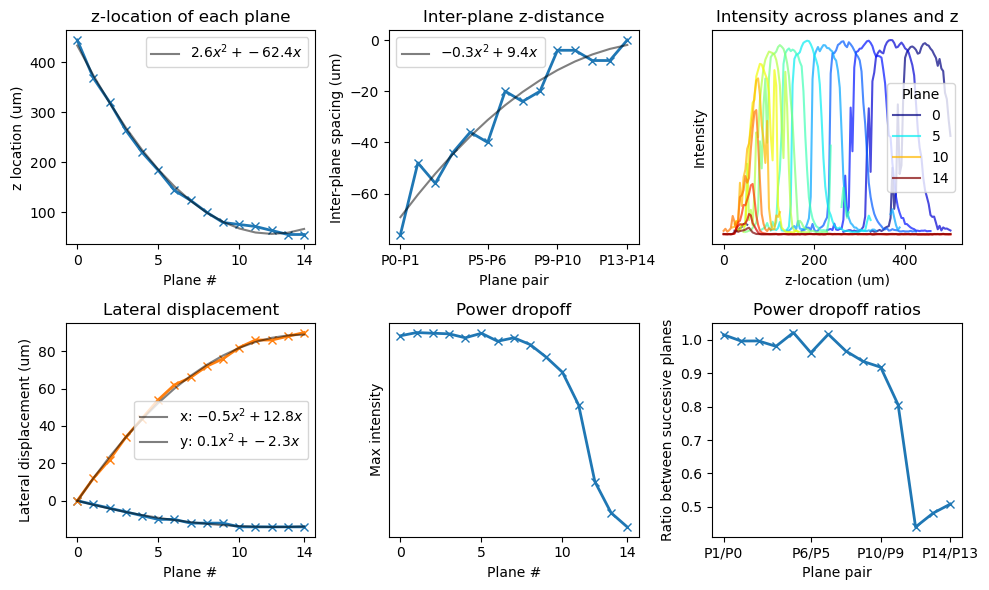

In [415]:
marker = 'x'
lw = 2
xticks = [0,5,10,14]

f,axs = plt.subplots(2,3, figsize=(10,6))

ax = axs[0][0]
ax.plot(planes, best_zpos_um, marker=marker, linewidth=lw)
ax.plot(planes, best_zpos_um_poly, color='k', alpha=0.5, label=('$%.1f x^2 + %.1f x$' % tuple(best_zpos_um_polyfit[:2])))
ax.set_xticks(xticks)
ax.set_xlabel("Plane #")
ax.set_ylabel("z location (um)")
ax.set_title("z-location of each plane")
ax.legend()

ax = axs[0][1]
ax.plot(inter_planes, inter_plane_um, marker=marker, linewidth=lw)
ax.plot(inter_planes, inter_plane_um_poly, color='k', alpha=0.5, label=('$%.1f x^2 + %.1f x$' % tuple(inter_plane_um_polyfit[:2])))
ax.set_xticks([0.5, 5.5, 9.5, 13.5], ['P0-P1', 'P5-P6', 'P9-P10', 'P13-P14'])
ax.legend()
ax.set_xlabel("Plane pair")
ax.set_ylabel("Inter-plane spacing (um)")
ax.set_title("Inter-plane z-distance")

ax = axs[0][2]
cmap = plt.get_cmap('jet', lut=n_channels)
lines = []
for i in range(n_channels):
    l = ax.plot(steps_um, sphere_vals_use[:,i], alpha=0.7, color=cmap(i))
    lines.append(l[0])
ax.legend([lines[i] for i in xticks], xticks, title = "Plane")
ax.set_xlabel("z-location (um)")
ax.set_ylabel("Intensity")
ax.set_yticks([])
ax.set_title("Intensity across planes and z")

ax = axs[1][0]
ax.plot(planes, xy_pos_um, linewidth=lw, marker=marker,)
ax.plot(planes, x_pos_poly, color='k', alpha=0.5, label=('x: $%.1f x^2 + %.1f x$' % tuple(x_pos_polyfit[:2])))
ax.plot(planes, y_pos_poly, color='k', alpha=0.5, label=('y: $%.1f x^2 + %.1f x$' % tuple(y_pos_polyfit[:2])))
ax.set_xticks(xticks)
ax.set_xlabel("Plane #")
ax.set_ylabel("Lateral displacement (um)")
ax.set_title("Lateral displacement")
ax.legend()

ax = axs[1][1]
ax.plot(planes, best_powers, linewidth=lw, marker=marker,)
ax.set_xticks(xticks)
ax.set_xlabel("Plane #")
ax.set_ylabel("Max intensity")
ax.set_title("Power dropoff")
ax.set_yticks([])

ax = axs[1][2]
ax.plot(inter_planes, power_ratios, marker=marker, lw=lw)
ax.set_xticks([0.5, 5.5, 9.5, 13.5], ['P1/P0', 'P6/P5', 'P10/P9', 'P14/P13'])
ax.set_xlabel("Plane pair")
ax.set_ylabel("Ratio between succesive planes")
ax.set_title("Power dropoff ratios")

plt.tight_layout()

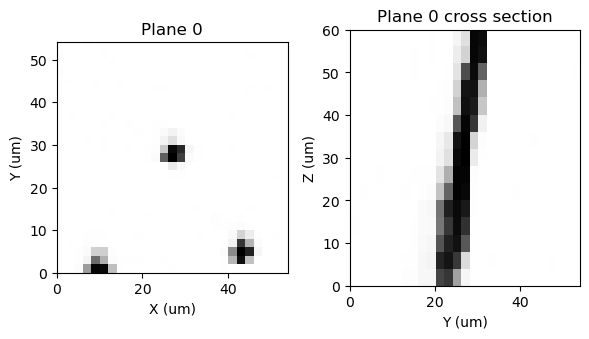

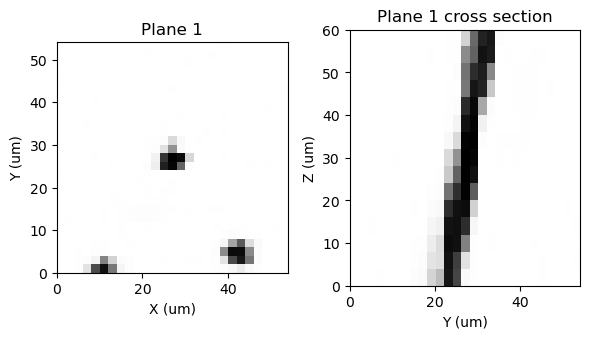

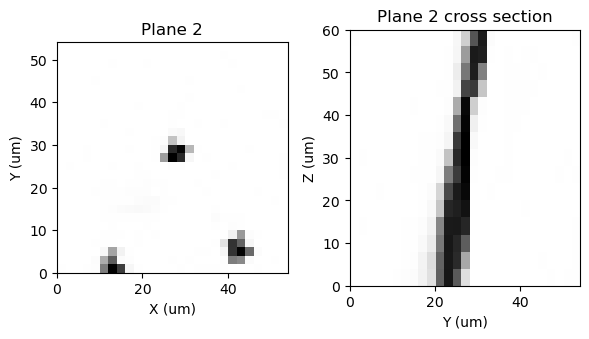

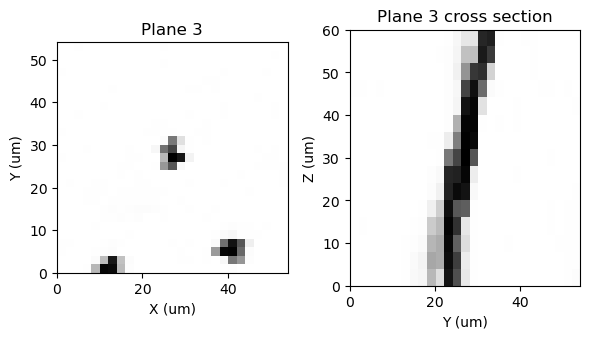

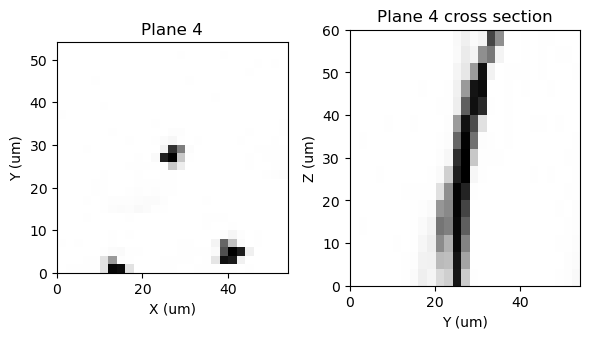

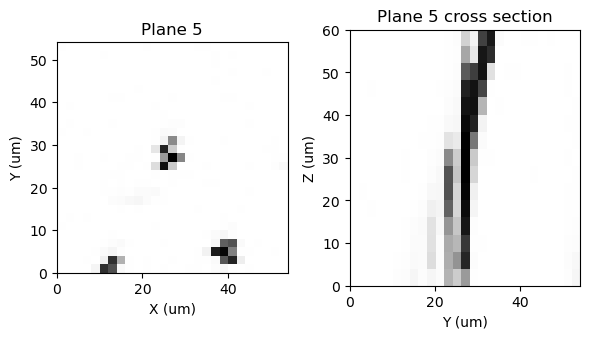

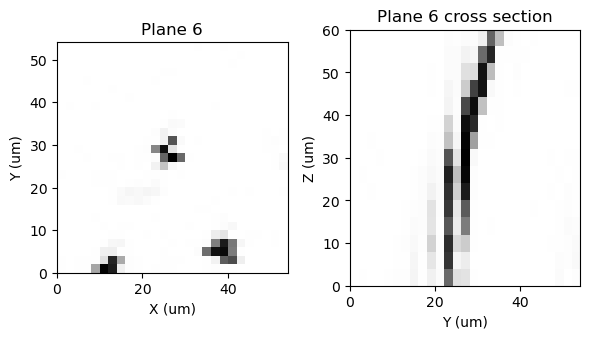

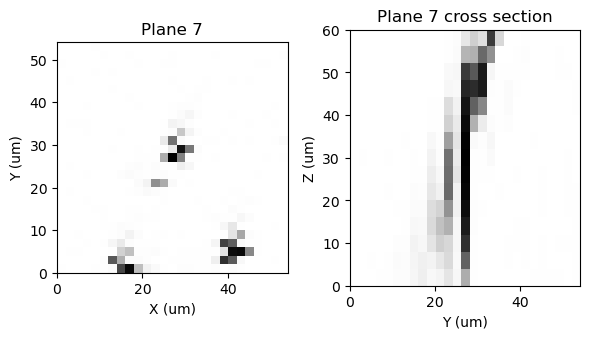

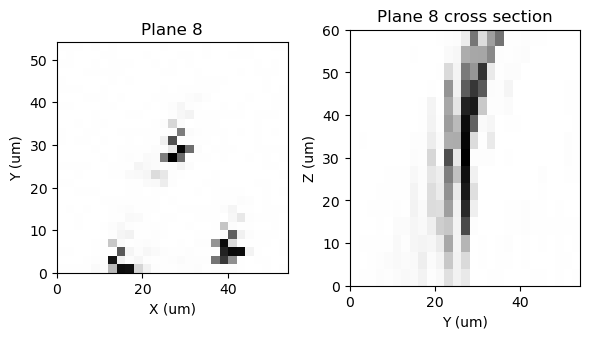

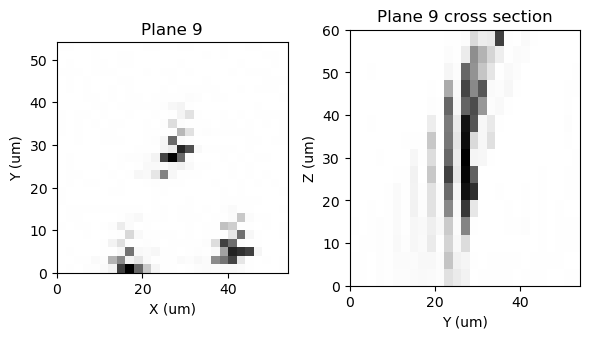

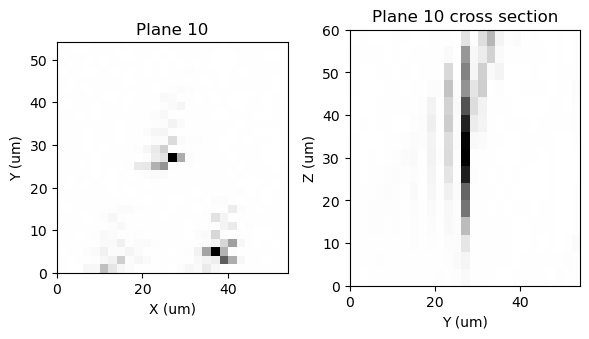

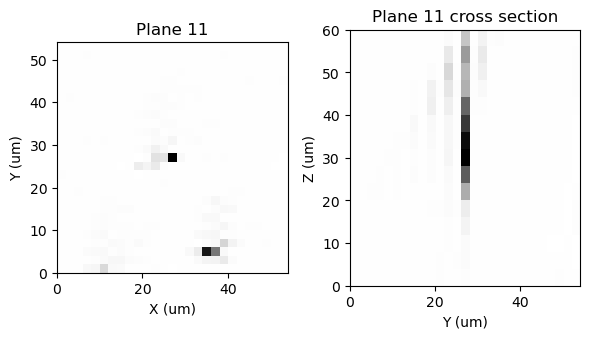

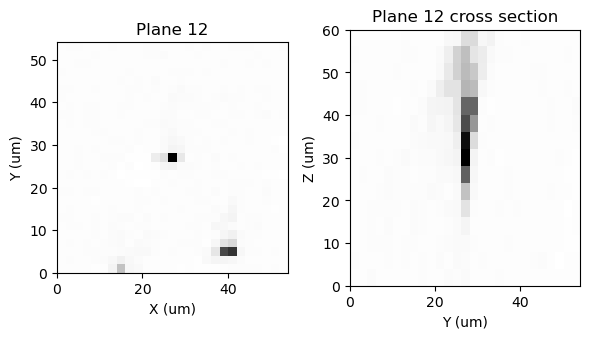

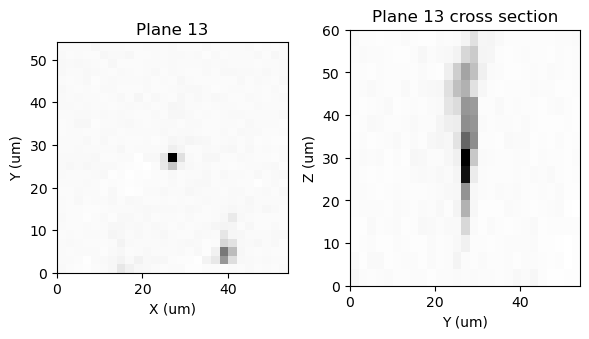

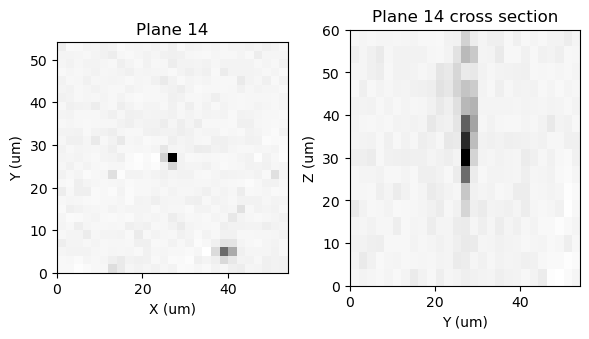

In [491]:
z0 = 13
for z0 in range(n_channels):
    s0, y0, x0 = sphere_coords[z0]
    
    zy_section = data[s0-ds:s0+ds+1, z0, y0-dy:y0+dy+1, x0]
    yx_section = data[s0, z0, y0-dy:y0+dy+1, x0-dx:x0+dx+1]
    f,axs = plt.subplots(1,2, figsize=(6,4))
    ax = axs[0]
    im = ax.imshow(yx_section, cmap='Greys', vmin=n.percentile(yx_section,0), vmax=n.percentile(yx_section,100),
              extent = [0, (2*dx+1)*psize_x, 0, (2*dy+1)*psize_y, ], aspect = 1)
    ax.set_xlabel("X (um)")
    ax.set_ylabel("Y (um)")
    ax.set_title("Plane %d" % z0)
    ax = axs[1]
    im = ax.imshow(zy_section, cmap='Greys', vmin=n.percentile(zy_section,0), vmax=n.percentile(zy_section,100),
              extent = [0,(2*dy+1)*psize_y, 0, (2*ds+1)*zstep_um],aspect = 1)
    ax.set_xlabel("Y (um)")
    ax.set_ylabel("Z (um)")
    ax.set_title("Plane %d cross section" % z0)
    plt.tight_layout()